In [1]:
import pickle
from pathlib import Path

In [2]:
# set the seeds to make the notebook reproducible
import lightning as L
import matplotlib.pyplot as plt

# Regression with MNIST-1D

In order to make our lives a bit easier, we will use a simplified dataset called [MNIST1D](https://github.com/greydanus/mnist1d). This dataset is small and yet exposes quite some intricacies.

import pickle
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch

L.seed_everything(41)

Seed set to 41


41

Download the MNIST1d demo dataset at [this URL](https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl) using your browser
or download the dataset directly from this notebook by uncommenting the following lines:

In [4]:
# import requests
# with open('mnist1d_data.pkl', 'wb') as out_file:
#    out_file.write(requests.get('https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl').content)

In [5]:
# load the dataset into this notebook
output = Path("./mnist1d_data.pkl")
data = pickle.load(output.open("rb"))

## Step 1: Visualize dataset

The dataset is inspired by the original MNIST dataset, but it is way smaller and 1D only.

In [6]:
x = data["x"]
y = data["y"]
x_test = data["x_test"]
y_test = data["y_test"]
t = data["t"]
print("training", x.shape, y.shape)
print("test", x_test.shape, y_test.shape)

training (13500, 24) (13500,)
test (1500, 24) (1500,)


## Step 2: Normalisation

The signal in the mnist1d dataset is not normalized. We need to perform normalisation before we can proceed. We choose a min-max normalisation.

In [7]:
xmin, xmax = x.min(), x.max()
print(f"min/max of x: {xmin, xmax}")

min/max of x: (-3.95753393168845, 4.098753451896514)


In [8]:
x_ = (x - xmin) / (xmax - xmin)
x_test_ = (x_test - xmin) / (
    xmax - xmin
)  # we need to apply the same normalisation constants to the test set

print(
    f"normalisation: raw min/max {x.min(), x.max()} -> normed min/max {x_.min(), x_.max()}"
)

normalisation: raw min/max (-3.95753393168845, 4.098753451896514) -> normed min/max (0.0, 1.0)


## Step 3: prepare training

Torch is a bit peculiar with respect to the encoding of the the signals. We need to inject a dimension in all data.

In [9]:
# 1D Convolutions are special, they need an additional axis inserted
# which represents the number of channels being present
x_ = np.expand_dims(x_, axis=1)
assert x_.shape == (
    x.shape[0],
    1,
    x.shape[-1],
), f"{x_.shape} does not match {x.shape[0], 1, x.shape[-1]}"
x_test_ = np.expand_dims(x_test_, axis=1)
y = np.expand_dims(y, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(x_.shape, y.shape)
print(x_test_.shape, y_test.shape)

(13500, 1, 24) (13500, 1)
(1500, 1, 24) (1500, 1)


Let's create a simple 1D regression training set by computing the sum across all input channels. Thus, we will have

- `x` - signals from mnist1d 
- `y` - the sum of mnist1d for a given `x`

(13500, 1, 1) (1500, 1, 1)


Text(0, 0.5, 'target sum(x)')

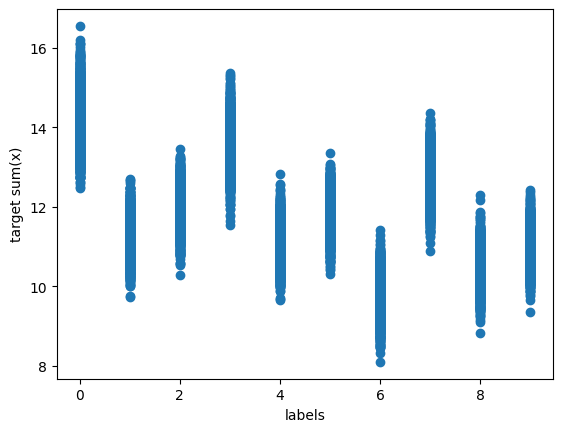

In [10]:
#Let's create a 1D training set
y_ = np.expand_dims(np.sum(x_,axis=-1),axis=-1)
y_test_ = np.expand_dims(np.sum(x_test_, axis=-1),axis=-1)

y_ *= np.random.randn(*y_.shape)/25. + 1.
y_test_ *= np.random.randn(*y_test_.shape)/25. + 1.

print(y_.shape,y_test_.shape)
plt.scatter(np.squeeze(y), np.squeeze(y_))
plt.xlabel("labels")
plt.ylabel("target sum(x)")

In [11]:
#let's check if there are any overlaps in our data
unique_y_=np.unique(y_)
unique_test_=np.unique(y_test_)
unique_all = np.unique(np.concatenate([y_,y_test_]))

print(unique_y_.shape, unique_test_.shape, unique_all.shape)

(13500,) (1500,) (15000,)


Text(0.5, 1.0, 'avg rel sigma 0.0432')

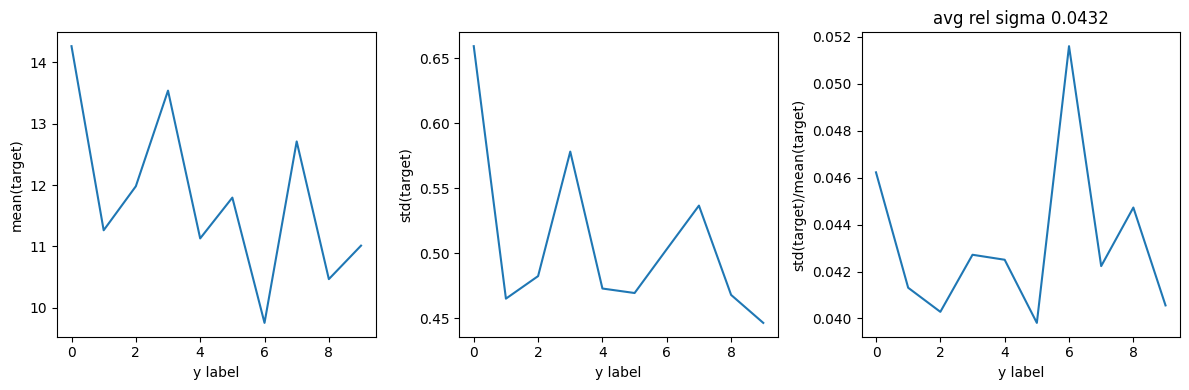

In [12]:
uy = np.unique(y)
uy_stat = []
my_stat = []
for yvalue in [ int(item) for item in uy ]:
    ymask = (y == yvalue)
    uy_stat.append(np.std(y_[ymask]))
    my_stat.append(np.mean(y_[ymask]))

fig, ax = plt.subplots(1,3,figsize=(12,4),tight_layout=True)
ax[0].plot(uy, my_stat)
ax[0].set_ylabel("mean(target)")
ax[0].set_xlabel("y label")


ax[1].plot(uy, uy_stat)
ax[1].set_ylabel("std(target)")
ax[1].set_xlabel("y label")


ax[2].plot(uy, np.asarray(uy_stat)/np.asarray(my_stat))
ax[2].set_ylabel("std(target)/mean(target)")
ax[2].set_xlabel("y label")
mean_rstd = np.mean(np.asarray(uy_stat)/np.asarray(my_stat))
ax[2].set_title(f"avg rel sigma {mean_rstd:04.4f}")

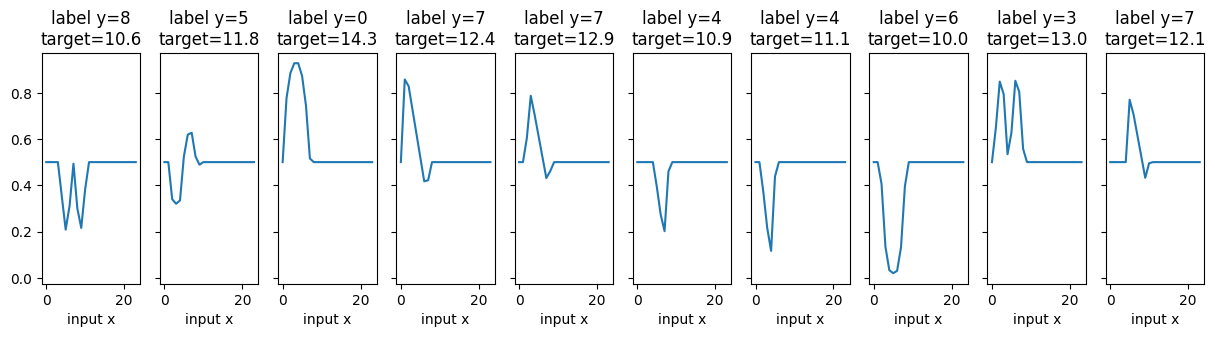

In [13]:
# let's plot the result, use the first 10 samples
n = 10
xaxis = np.arange(0, x_.shape[-1], 1)
fig, ax = plt.subplots(1, n, figsize=(15,3), sharey=True)
for i in range(n):
    ax[i].plot(xaxis, x_[i, 0, ...],label="original")
    ax[i].set_title(f"label y={y[i,0]}\ntarget={y_[i,0,0]:02.1f}")
    ax[i].set_xlabel(f"input x")

Convert everything to a `torch.Tensor` object.

In [14]:
x_, y = torch.tensor(x_, dtype=torch.float32), torch.tensor(y_, dtype=torch.float32)

In [15]:
from sklearn.model_selection import train_test_split

X_test, x_holdout, Y_test_, y_holdout = train_test_split(x_test_,y_test_,test_size=500)
x_holdout = x_holdout.astype(np.float32)
y_holdout = y_holdout.astype(np.float32)


(1000, 1, 24) (500, 1, 24) (1000, 1, 1) (500, 1, 1)
float64 float32 float64 float32


In [16]:
x_test_, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(
    Y_test_, dtype=torch.float32
)

Text(0.5, 1.0, 'holdout')

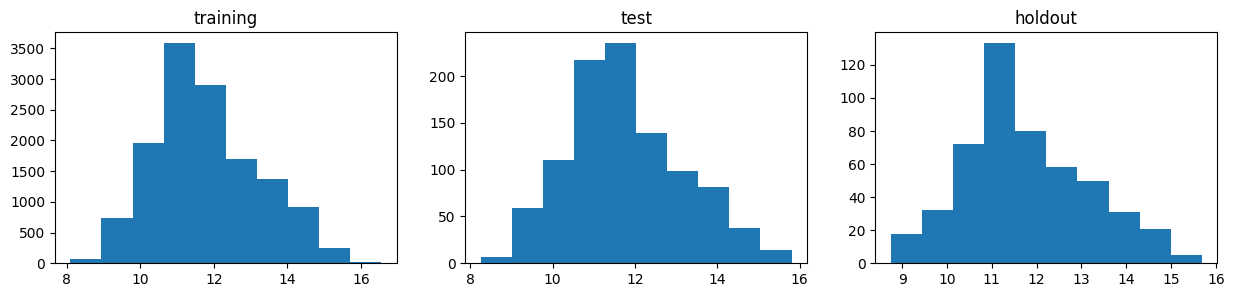

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
ax[0].hist(y.numpy().squeeze())
ax[0].set_title("training")
ax[1].hist(y_test.numpy().squeeze())
ax[1].set_title("test")
ax[2].hist(np.squeeze(y_holdout))
ax[2].set_title("holdout")

# creating the models

In [18]:
class EnsembleMLP(torch.nn.Module):

    def __init__(
        self,
        inshape: tuple = x_.shape,
        channels: int = 2 * x_.shape[-1],
        dropout: float = 0.3,
    ):
        """
        Creates a simple multi-layer perceptron (MLP) to regress the 1D signal.

        Parameters
        ----------
        inshape : tuple, optional
        The input shape of the MLP, by default x_.shape
        channels : int, optional
        The number of channels in the MLP, by default 2*x_.shape[-1]
        dropout : float, optional
        The dropout rate for the MLP, by default 0.3

        Notes
        -----
        This model is adopted from https://github.com/greydanus/mnist1d/blob/39dd6c03785eefe60f349af94e61f864fc449644/models.py#L36

        Examples
        --------
        >>> x = torch.randn(100, 28, 28)
        >>> model = EnsembleMLP(inshape=x.shape)
        >>> y = model(x)
        """

        super(EnsembleMLP, self).__init__()

        self.sigma_offset = 1e-8
        self.base_layers = torch.nn.Sequential(
            torch.nn.Linear(inshape[-1], channels),
            torch.nn.ReLU(),
            
            #torch.nn.Linear(channels, channels),
            #torch.nn.ReLU(),
            
            #torch.nn.Linear(channels, channels),
            #torch.nn.ReLU(),
            
            #torch.nn.Dropout(p=dropout),
            # torch.nn.Linear(channels, channels),
            # torch.nn.ReLU()
        )

        self.mu = torch.nn.Sequential(
            torch.nn.Linear(channels, 1),
            # to get back to output range of [0,1]
        )
        self.sigma = torch.nn.Sequential(
            torch.nn.Linear(channels, 1), torch.nn.Softplus()
            # use softplus to ensure only positive values
        )

    def forward(self, x):
        """

        forward pass through the model

        Parameters
        ----------
        x : torch.Tensor
            the input tensor (i.e. batch) to process

        Returns: tuple of size 2
            mean: mean predicted values given x
            sigma: predicted standard deviations given x
        """
        y = self.base_layers(x)

        return self.mu(y), self.sigma(y)

In [19]:
# create a mlp style model
mlp = EnsembleMLP(x_.shape, channels=48, dropout=0.65)
mlp

EnsembleMLP(
  (base_layers): Sequential(
    (0): Linear(in_features=24, out_features=48, bias=True)
    (1): ReLU()
  )
  (mu): Sequential(
    (0): Linear(in_features=48, out_features=1, bias=True)
  )
  (sigma): Sequential(
    (0): Linear(in_features=48, out_features=1, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
  )
)

In [20]:
# check if mlp model prediction works
print(x_[:2, 0].shape)
mn, si = mlp(x_[:2, 0])
print(f"mlp predictions return <mu> {mn.shape} and <sigma> {si.shape}")

torch.Size([2, 24])
mlp predictions return <mu> torch.Size([2, 1]) and <sigma> torch.Size([2, 1])


In [25]:
def fit_model(
    data_train,
    data_val,
    model,
    optimizer_cls,
    scheduler_cls=None,
    # loss_fn,
    batch_size=64,
    epochs=50,
    validation_interval=1
):
    """run the training loop"""

    optimizer = optimizer_cls(model.parameters())
    scheduler = scheduler_cls(optimizer) if scheduler_cls else None

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(data_train[0], data_train[1]),
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(data_val[0], data_val[1]),
        batch_size=batch_size,
        shuffle=False,
    )

    train_losses = []
    val_losses = []
    val_avg_mse = []
    val_avg_rstd = []
    for epoch in range(epochs):
        epoch_losses_train = train_epoch(model, train_loader, optimizer)  # , loss_fn

        avg_train_loss = np.mean(epoch_losses_train)
        train_losses.append((epoch, avg_train_loss))

        if epoch % validation_interval == 0:
            epoch_losses_val, epoch_mse_val, epoch_rstd_val = run_validation(model, val_loader)  # , loss_fn
            
                
            avg_rstd = np.mean(epoch_rstd_val)
            avg_mse  = np.mean(epoch_mse_val)
            avg_val_loss = np.mean(epoch_losses_val)
            
                
            val_avg_mse.append((epoch, avg_mse))
            val_avg_rstd.append((epoch, avg_rstd))
            val_losses.append((epoch, avg_val_loss))
            
            print(
                f"{scheduler.get_last_lr()} Epoch {epoch+1}/{epochs}: Train/Test loss {avg_train_loss:04.3f} {avg_val_loss:04.3f}, avg test mse/rstd {avg_mse:02.05f} {avg_rstd:02.05f}"
            )
            
            if scheduler and hasattr(scheduler,"step"):
                scheduler.step(avg_val_loss)
        else:
            print(f"{scheduler.get_last_lr()} Epoch {epoch+1}/{epochs}: Train loss {avg_train_loss:04.3f}")

    return train_losses, val_losses, val_avg_mse, val_avg_rstd


def train_epoch(model, train_loader, optimizer):
    """perform one training epoch"""
    model.train()
    epoch_losses_train = []
    
        
    for train_batch in train_loader:
        inputs, labels = train_batch
        pred_mean, pred_sigma = model(inputs)

        pred_sigma += model.sigma_offset
        loss_ = 0.5 * torch.log(pred_sigma**2 )
        loss_ += 0.5 * ((labels - pred_mean)**2 / (pred_sigma)**2)
        loss = loss_.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.detach().cpu().numpy())

    return epoch_losses_train


def run_validation(model, val_loader):
    """perform one validation run"""
    model.eval()

    epoch_losses_val = []
    epoch_rstd_val = []
    epoch_mse_val = []
    with torch.no_grad():
        for val_batch in val_loader:
            inputs, labels = val_batch
            pred_mean, pred_sigma = model(inputs)
            pred_sigma += model.sigma_offset
            
            val_loss_ = 0.5 * torch.log(pred_sigma**2)
            val_loss_ += 0.5 * ((labels - pred_mean) / (pred_sigma))**2
            val_loss = val_loss_.mean()

            epoch_rstd_val.append((pred_sigma/pred_mean).detach().cpu().numpy())
            epoch_mse_val.append((pred_mean.detach().cpu().numpy()-labels.detach().numpy())**2)
            epoch_losses_val.append(val_loss.detach().cpu().numpy())

    return np.asarray(epoch_losses_val), np.concatenate(epoch_mse_val), np.concatenate(epoch_rstd_val)

def init_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv1d):
        #torch.nn.init.normal_(m.weight, .1,.01)
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
        

## Perform Training

In [26]:
from functools import partial

optimizer_cls = partial(torch.optim.Adam, lr=0.0001, betas=(0.9, 0.999), eps=1.0e-7)
scheduler_cls = partial(torch.optim.lr_scheduler.ReduceLROnPlateau,mode='min',patience=5)


In [27]:
batch_size = 64
epochs = 35
validation_interval = 1  # every how many epochs should we run validation

In [28]:
model = EnsembleMLP(x_.shape, channels=64, dropout=0.)
model.apply(init_weights)

train_losses, val_losses, val_avg_mse, val_avg_rstd = fit_model(
    data_train=(x_, y),
    data_val=(x_test_, y_test),
    model=model,
    optimizer_cls=optimizer_cls,
    scheduler_cls =scheduler_cls,
    batch_size=batch_size,
    epochs=epochs,
    validation_interval=validation_interval,
    
)

[0.0001] Epoch 1/35: Train/Test loss 17.493 10.000, avg test mse/rstd 142.08746 33.96659
[0.0001] Epoch 2/35: Train/Test loss 7.460 5.719, avg test mse/rstd 122.72149 5.10590
[0.0001] Epoch 3/35: Train/Test loss 4.852 4.122, avg test mse/rstd 102.05074 2.50695
[0.0001] Epoch 4/35: Train/Test loss 3.677 3.301, avg test mse/rstd 83.38000 1.80060
[0.0001] Epoch 5/35: Train/Test loss 3.065 2.849, avg test mse/rstd 67.78137 1.46541
[0.0001] Epoch 6/35: Train/Test loss 2.706 2.567, avg test mse/rstd 54.31990 1.25043
[0.0001] Epoch 7/35: Train/Test loss 2.471 2.373, avg test mse/rstd 42.71535 1.09220
[0.0001] Epoch 8/35: Train/Test loss 2.304 2.229, avg test mse/rstd 32.77882 0.96456
[0.0001] Epoch 9/35: Train/Test loss 2.174 2.110, avg test mse/rstd 24.35101 0.85411
[0.0001] Epoch 10/35: Train/Test loss 2.061 2.001, avg test mse/rstd 17.29140 0.75295
[0.0001] Epoch 11/35: Train/Test loss 1.951 1.889, avg test mse/rstd 11.49837 0.65622
[0.0001] Epoch 12/35: Train/Test loss 1.833 1.763, avg te

In [29]:
import seaborn as sns
import pandas as pd

def plot_history(train_losses, val_losses, legend=True, labels=["Training NLL", "Test NLL"], logy=False):
    """
    Plot the training history
    """

    train_epochs = [tup[0] for tup in train_losses]
    train_l = [tup[1] for tup in train_losses]

    val_epochs = [tup[0] for tup in val_losses]
    val_l = [tup[1] for tup in val_losses]

    history_df = pd.DataFrame()
    history_df["Epoch"] = train_epochs + val_epochs
    history_df["value"] = train_l + val_l
    history_df["Variable"] = [labels[0]] * len(train_epochs) + [labels[1]] * len(
        val_epochs
    )

    ax = sns.lineplot(
        data=history_df,
        x="Epoch",
        y="value",
        hue="Variable",
        legend="auto" if legend else False,
    )
    if logy:
        ax.set_yscale('log')


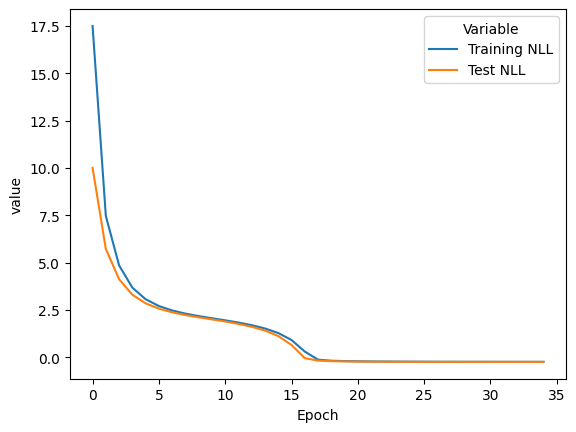

In [30]:
plot_history(train_losses, val_losses)

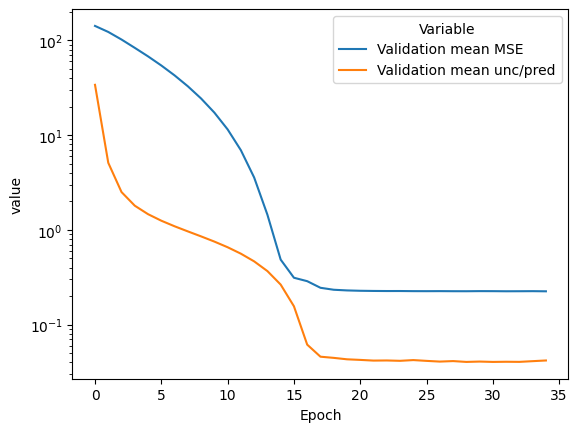

In [31]:
plot_history(val_avg_mse, val_avg_rstd, labels=["Validation mean MSE", "Validation mean unc/pred"], logy=True)

torch.Size([1000, 1, 1]) torch.Size([1000, 1, 1])


Text(0.5, 0, 'labels')

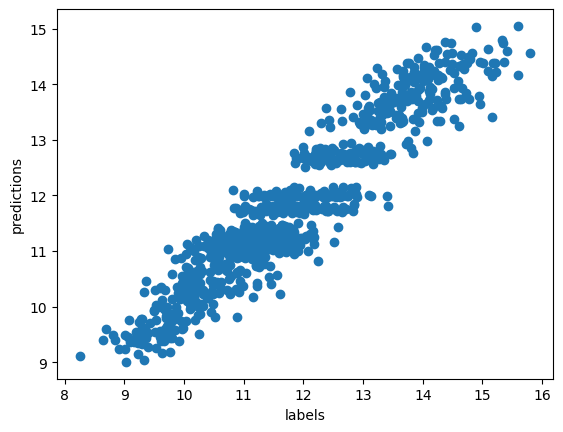

In [32]:
with torch.no_grad():
    pred, stddev = model(x_test_)
print(pred.shape, y_test.shape)

plt.scatter(y_test.squeeze().numpy(),pred.numpy())
plt.ylabel("predictions")
plt.xlabel("labels")

The above is not a great model, but it should suffice for the sake of the demonstration.

## Create a deep ensemble based estimate

The idea of Deep Ensembles was published in 2017 (after MCDropout) in
http://arxiv.org/abs/1612.01474 by  Lakshminarayanan et al

The core idea is to train multiple models on the same dataset. Each model then acts as a predictor to sample the uncertainties predicted. To this end, the more predictors you train, the longer your training will last.



In [33]:
num_predictors = 5
epochs = 50
models = []
histories = []
mse_rstd_log = []
for midx in range(num_predictors):
    #L.seed_everything(42+midx)
    
    model = EnsembleMLP(x_.shape, channels=64, dropout=0.)
    model.apply(init_weights)
    
    train_losses, val_losses, avg_mse_val, avg_rstd_val = fit_model(
        data_train=(x_, y),
        data_val=(x_test_, y_test),
        model=model,
        optimizer_cls=optimizer_cls,
        scheduler_cls=scheduler_cls,
        # loss_fn=loss_fn,
        batch_size=batch_size,
        epochs=epochs,
        validation_interval=validation_interval,
    )

    models.append(model)
    histories.append((train_losses, val_losses))
    mse_rstd_log.append((avg_mse_val, avg_rstd_val))
    print(f"\nModel {midx+1}/{num_predictors}: Training finished\n")

[0.0001] Epoch 1/50: Train/Test loss 161.608 78.639, avg test mse/rstd 134.50116 0.33009
[0.0001] Epoch 2/50: Train/Test loss 52.465 32.719, avg test mse/rstd 126.00838 2.55710
[0.0001] Epoch 3/50: Train/Test loss 24.118 17.405, avg test mse/rstd 116.46410 1.86445
[0.0001] Epoch 4/50: Train/Test loss 14.053 10.952, avg test mse/rstd 105.16041 1.46946
[0.0001] Epoch 5/50: Train/Test loss 9.228 7.680, avg test mse/rstd 94.62664 1.27629
[0.0001] Epoch 6/50: Train/Test loss 6.781 5.917, avg test mse/rstd 85.76907 1.16776
[0.0001] Epoch 7/50: Train/Test loss 5.378 4.834, avg test mse/rstd 77.92214 1.09191
[0.0001] Epoch 8/50: Train/Test loss 4.481 4.113, avg test mse/rstd 70.80913 1.03291
[0.0001] Epoch 9/50: Train/Test loss 3.866 3.603, avg test mse/rstd 64.26125 0.98396
[0.0001] Epoch 10/50: Train/Test loss 3.424 3.228, avg test mse/rstd 58.18056 0.94156
[0.0001] Epoch 11/50: Train/Test loss 3.094 2.944, avg test mse/rstd 52.51498 0.90370
[0.0001] Epoch 12/50: Train/Test loss 2.840 2.723,

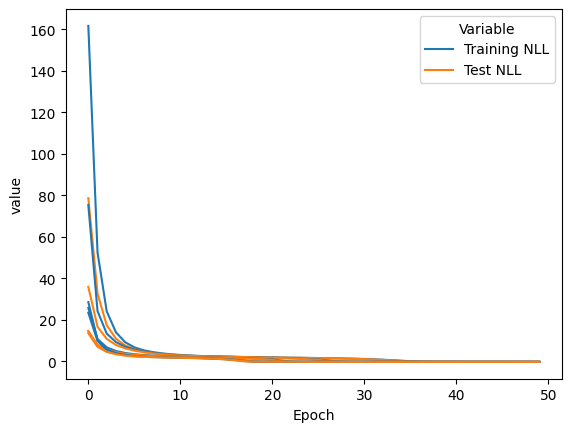

In [34]:
# plot the training progress of the ensemble of predictors
for idx, (train_losses, val_losses) in enumerate(histories):
    plot_history(train_losses, val_losses, legend=idx == 0)

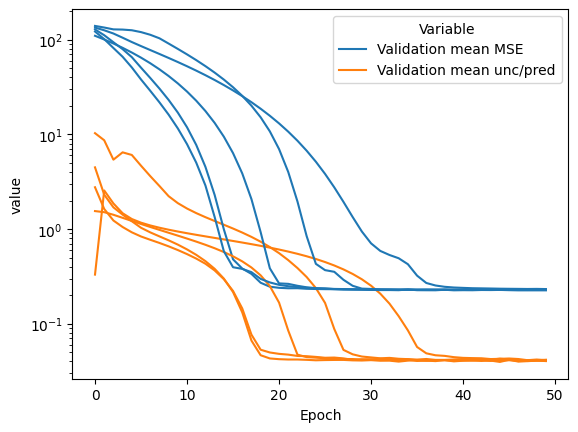

In [35]:
for idx, (mse_vals, rstd_vals) in enumerate(mse_rstd_log):
    plot_history(mse_vals, rstd_vals, labels=["Validation mean MSE", "Validation mean unc/pred"], logy=True, legend=idx == 0)

### How to do predictions?

We average across all predictions. The core assumption of the DeepEnsemble approach is, that each prediction is created by a sum of Gaussians around the "true" value.

In [36]:
def get_predictions(model, loader):
    """obtain predictions for one <model> given the data provided by <loader>

    Parameters
    ----------
        model : torch.nn.Module
            the model to build the ensemble with
        loader : torch.DataLoader
            the data loader to use


    Returns: tuple of size 2
        inputs: a concatenation of inputs
        preds: a concatenation of all produced predictions
    """
    model.eval()

    inputs = []
    preds = []
    stds = []
    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            y_pred, y_std = model(x)

            inputs.append(x.detach().cpu().numpy())
            preds.append(y_pred.detach().cpu().numpy())
            stds.append(y_std.detach().cpu().numpy())

    return np.concatenate(inputs, axis=0), np.concatenate(preds, axis=0), np.concatenate(stds, axis=0)

In [37]:
num_preds = 16  # number of predictions to check

inference_x = x_test_
inference_y = y_test

inference_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inference_x, inference_y),
    batch_size=len(inference_x),
    shuffle=False,
)

locs = []
scales = []
for idx,m in enumerate(models):
    _, preds, stds = get_predictions(m, inference_loader)
    locs.append(preds)
    scales.append(stds)

estimates = np.concatenate(locs,axis=1)
stddevs = np.concatenate(scales,axis=1)
print(
    f"Obtained {num_preds} predictions from {num_predictors} models in ensemble. This yielded shape {estimates.shape}."
)
assert estimates.shape[0] > num_preds
assert estimates.shape[1] == num_predictors
assert estimates.shape[-1] == inference_y.shape[-1]

Obtained 16 predictions from 5 models in ensemble. This yielded shape (1000, 5, 1).


In [38]:
mixture_mean = np.mean(estimates, axis=1)
mixture_var = (
    np.mean(stddevs**2 + estimates**2, axis=1) - mixture_mean**2
)  # end of section 2.4 of Lakshminarayanan2017, equals sigma**2
# Note: as a safeguard, do check if any variances are smaller than 0
mixture_var[mixture_var < 0.0] = 0.0
mixture_std = np.sqrt(mixture_var)

# check the shape of the summary statistics of the DeepEnsemble ensemble
print(mixture_mean.shape, mixture_var.shape, np.min(mixture_var), np.max(mixture_var))

(1000, 1) (1000, 1) 0.1515503 0.3600769


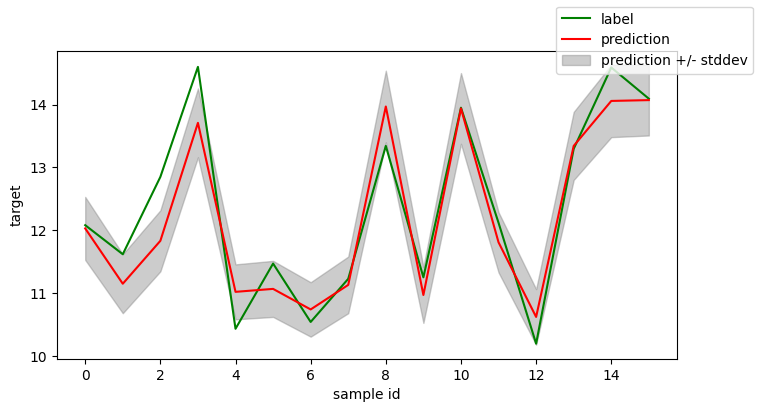

In [39]:
from matplotlib.lines import Line2D

n = num_preds


fig, ax = plt.subplots(1, 1, figsize=(n * .5, 4), sharey=True)
xaxis = np.arange(0, n)

ax.plot(xaxis, y_test[:n].squeeze().numpy(), color="green", label="label")
ax.plot(xaxis, np.squeeze(mixture_mean)[:n], color="red", label="prediction")
ax.fill_between(
        xaxis,
        np.squeeze(mixture_mean - mixture_std)[:n],
        np.squeeze(mixture_mean + mixture_std)[:n],
        color="grey",
        label="prediction +/- stddev",
        alpha=0.4,
    )

ax.set_xlabel("sample id")
ax.set_ylabel("target")
fig.legend()
fig.savefig("ensemble_regression_fcn.pdf")

In [41]:
# now predictions for all of the test data
inference_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.Tensor(x_holdout), torch.Tensor(y_holdout)),
    batch_size=batch_size,
    shuffle=False,
)

locs = []
scales = []
for idx,m in enumerate(models):
    _, preds, stds = get_predictions(m, inference_loader)
    locs.append(preds)
    scales.append(stds)

y_predictions = np.concatenate(locs, axis=1)
y_stddevs = np.concatenate(scales, axis=1)

print(y_predictions.shape, y_stddevs.shape)

(500, 5, 1) (500, 5, 1)


# Calibration plots


An important aspect of uncertainty quantification is to assess if the predictive uncertainties are of high quality. We will use a library called `uncertainty-toolbox` for this. It will lift the burdon for certain (tricky) operations from our fingers. The [project's landing page](https://github.com/uncertainty-toolbox/uncertainty-toolbox) will provide more details.

In [42]:

# calculating mu of mixture
y_mean = np.mean(y_predictions, axis=1)

# calculating sigma^2 of mixture
y_var = (
    np.mean(y_stddevs**2 + y_predictions**2, axis=1) - y_mean**2
)  # end of section 2.4 of Lakshminarayanan2017, note this is sigma**2
# Note: as a safeguard, do check if any variances are smaller than 0


print(y_var.min(), y_var.mean(), y_var.max())
y_var[y_var < 0.0] = 1e-8
y_std = np.sqrt(y_var)


0.15088654 0.23614807 0.35437012
(500, 1) (500, 1) (1000, 1, 1) 500
0.38844118 0.48385084 0.59528995


Text(0.5, 1.0, 'Average Calibration Holdout Set')

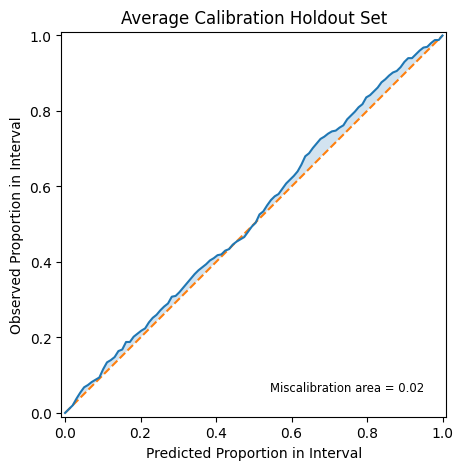

In [43]:
from uncertainty_toolbox.viz import plot_calibration, plot_intervals, plot_intervals_ordered

ax = plot_calibration(y_mean.flatten(), y_std.flatten(), y_holdout.flatten())
ax.set_title("Average Calibration Holdout Set")

(1000, 1) (1000, 1) torch.Size([1000, 1, 1])


Text(0.5, 1.0, 'Average Calibration Test Set')

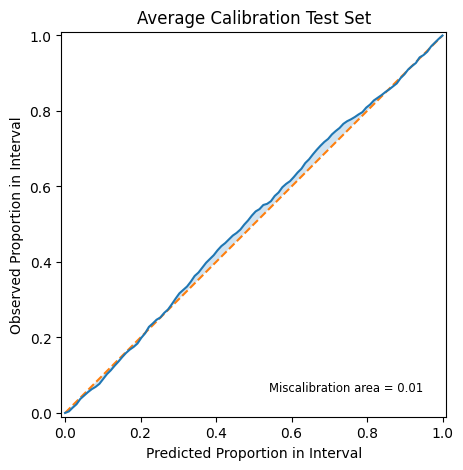

In [44]:
ax = plot_calibration(mixture_mean.flatten(), mixture_std.flatten(), y_test.numpy().flatten())
ax.set_title("Average Calibration Test Set")

As the calibration curve is aligned with the diagonal, we would consider this DeepEnsemble approximation a good approximation! The miscalibration area is very small (`0.01`).


## Task: Repeat the above

Repeat the exercise above, but this time change the model to your liking. Play around with the model definition a bit.

- Can you find a variant of the MLP that performs better/worse on the MSE loss?
- if you have found such a variant, what happens to the calibration plot?

